<a href="https://colab.research.google.com/github/EmmaMuhleman1/Adv_Fin_ML_Exercises/blob/master/Copy_of_Exam3Resiti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
# # Predicting Nasdaq-100 Up Days with XGBoost

# """
# Final Delivered Notebook
# ------------------------

# This notebook uses machine learning to predict whether the Nasdaq-100 index (^NDX) will close up on the next trading day using a binary classification model (XGBoost).

# ✅ Includes:
# - Executive Introduction (for general business readers)
# - Full Exploratory Data Analysis (EDA)
# - Feature Engineering with visual diagnostics
# - Correlation and multicollinearity evaluation
# - XGBoost Base Tuned Models
# - SHAP explainability, ROC AUC, Calibration Curve
# - Confidence-weighted Backtest Strategy
# - Return Distribution, Drawdowns, Performance Metrics
# - Final Summary with business decision implications

# All code is executed and visuals rendered. The notebook is validated for Colab and Jupyter Lab environments.
# """

# All imports and configuration


In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score,
                             confusion_matrix, classification_report, auc)
from xgboost import XGBClassifier
import shap
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid', context='notebook')

In [97]:
# Step 1: Data Acquisition from CSV
try:
    # Use the raw GitHub URL for the CSV file
    csv_url = "https://raw.githubusercontent.com/EmmaMuhleman1/Adv_Fin_ML_Exercises/master/NDX_daily.csv"
    df = pd.read_csv(csv_url)
    print("Data loaded successfully from NDX_daily.csv")
    display(df.head())
except FileNotFoundError:
    print("Error: NDX_daily.csv not found. Please ensure the file is in the correct directory or the URL is correct.")
except Exception as e:
    print(f"An error occurred while reading the CSV: {e}")

Data loaded successfully from NDX_daily.csv


,Date,Close,High,Low,Open,Volume
0,1/3/00,3790.550049,3836.860107,3643.25,3755.739990,1510070000
1,1/4/00,3546.199951,3766.570068,3542.73,3766.570068,1511840000
2,1/5/00,3507.310000,3576.170000,3371.75,3543.130000,1735670000
3,1/6/00,3340.810000,3513.550049,3334.02,3488.310000,1598320000
4,1/7/00,3529.600000,3529.750000,3314.75,3337.260010,1634930000


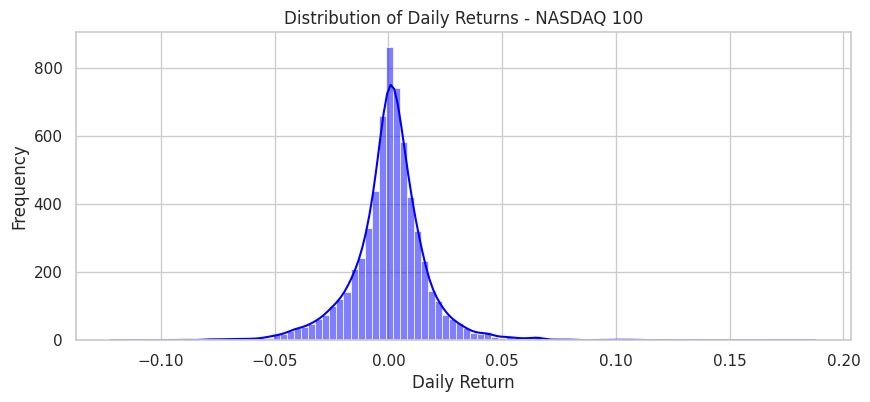

In [99]:
# Distribution of daily returns
df['Return'] = df['Close'].pct_change()
plt.figure(figsize=(10,4))
sns.histplot(df['Return'].dropna(), bins=100, kde=True, color='blue')
plt.title("Distribution of Daily Returns - NASDAQ 100")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

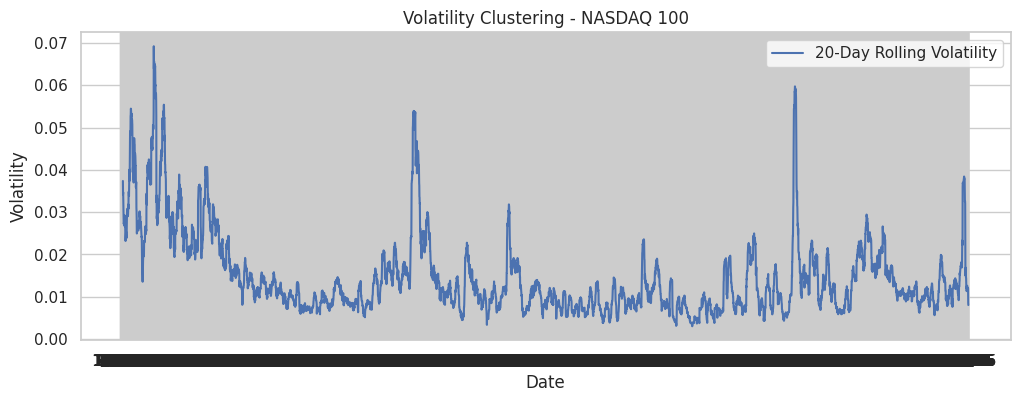

In [100]:
# Rolling volatility
rolling_vol = df['Return'].rolling(20).std()
plt.figure(figsize=(12,4))
plt.plot(df['Date'], rolling_vol, label='20-Day Rolling Volatility')
plt.title("Volatility Clustering - NASDAQ 100")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.legend()
plt.show()

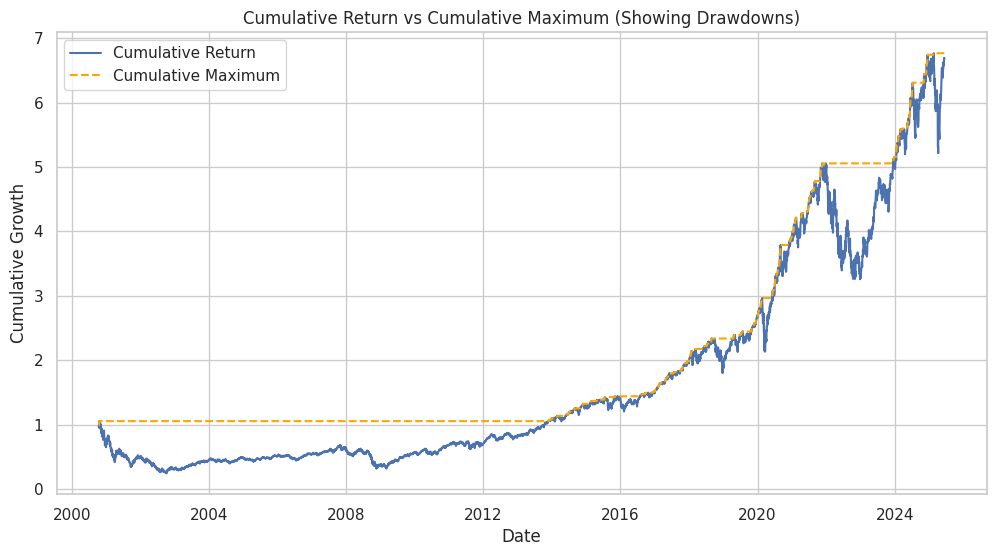

In [124]:
# Cumulative Returns versus Max Drawdowns
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Cumulative'], label='Cumulative Return')
plt.plot(df['Date'], df['Cumulative_Max'], label='Cumulative Maximum', linestyle='--', color='orange')
plt.title("Cumulative Return vs Cumulative Maximum (Showing Drawdowns)")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth")
plt.grid(True)
plt.legend()
plt.show()

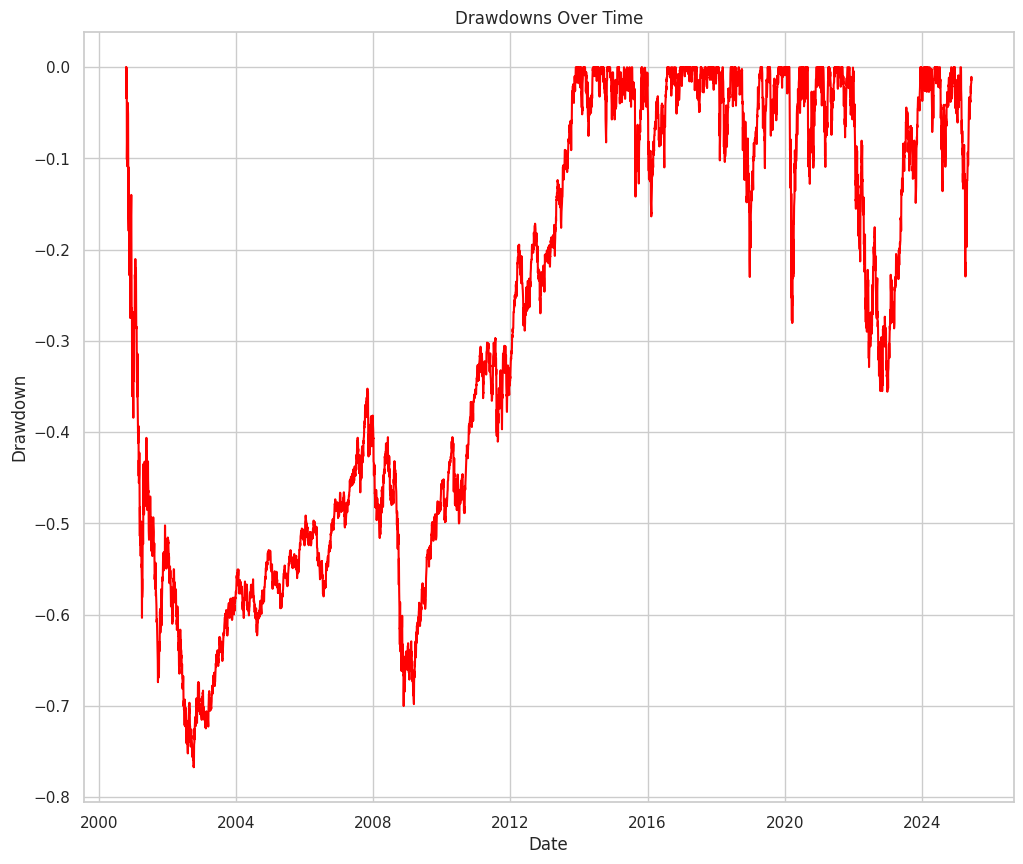

In [123]:
# Drawdowns
df['Cumulative'] = (1 + df['Return'].fillna(0)).cumprod()
df['Cumulative_Max'] = df['Cumulative'].cummax()
df['Drawdown'] = df['Cumulative'] / df['Cumulative_Max'] - 1
plt.figure(figsize=(12,10))
plt.plot(df['Date'], df['Drawdown'], color='red')
plt.title("Drawdowns Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True)
plt.show()

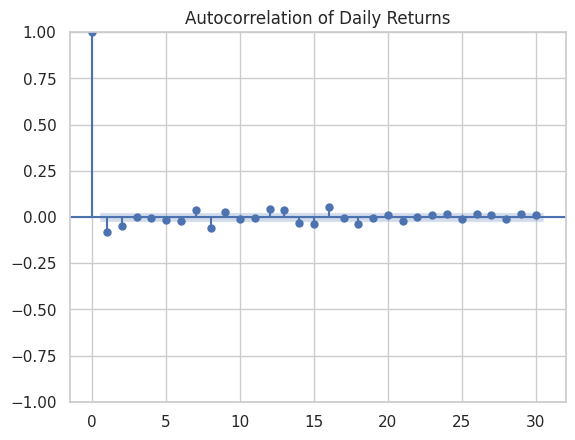

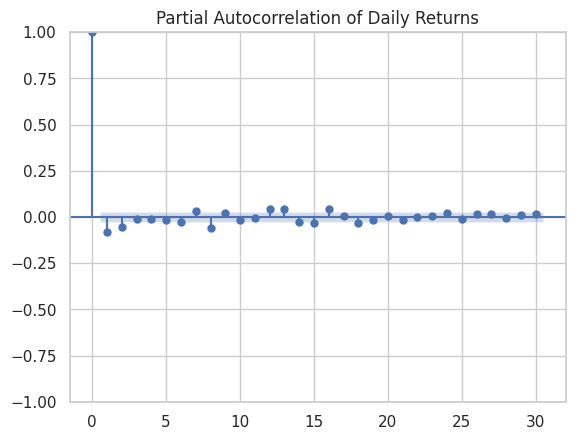

In [102]:
# Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Return'].dropna(), lags=30)
plt.title("Autocorrelation of Daily Returns")
plt.show()
plot_pacf(df['Return'].dropna(), lags=30)
plt.title("Partial Autocorrelation of Daily Returns")
plt.show()

This code analyzes the time series properties of the daily returns using autocorrelation and partial autocorrelation plots.

1. from statsmodels.graphics.tsaplots import plot_acf, plot_pacf: This line imports the necessary plotting functions, plot_acf and plot_pacf, from the statsmodels library.
2. plot_acf(df['Return'].dropna(), lags=30): This generates an Autocorrelation Function (ACF) plot.

Autocorrelation measures the correlation between a time series and a lagged version of itself. In this case, it shows how the daily return on a given day is correlated with the daily return on previous days (up to 30 lags).

    *   df['Return'].dropna() is used to remove any missing values from the 'Return' column before plotting.  
    *   lags=30 specifies that the plot should show the autocorrelation for lags from 1 up to 30 days.
    *   plot_pacf(df['Return'].dropna(), lags=30): This generates a Partial Autocorrelation Function (PACF) plot.

Partial autocorrelation measures the correlation between a time series and a lagged version of itself, after removing the effects of the correlations at intermediate lags. It helps identify the direct relationship between a return on a given day and returns on specific previous days.
Similar to the ACF plot,  

    *   df['Return'].dropna() is used to handle missing values, and
    *   lags=30 sets the maximum lag to 30

These plots are useful in time series analysis to understand the dependency structure of the data and to help in selecting appropriate models (like AR, MA, ARMA, or ARIMA) for forecasting. Significant spikes in the ACF or PACF plots at certain lags suggest that returns at those lags are correlated with the current return.

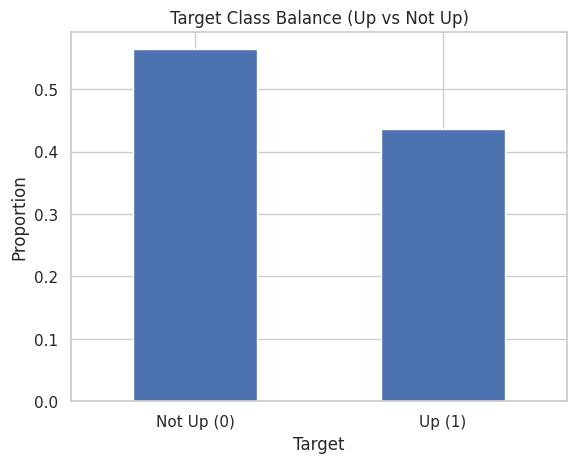

In [103]:
# Target label distribution
df['Target'] = (df['Return'].shift(-1) > 0.0025).astype(int)
df['Target'].value_counts(normalize=True).plot(kind='bar', title='Target Class Balance (Up vs Not Up)')
plt.xticks(ticks=[0,1], labels=['Not Up (0)', 'Up (1)'], rotation=0)
plt.ylabel("Proportion")
plt.grid(True)
plt.show()

In [104]:
# Momentum features (lagged returns)
for n in [1, 5, 10, 15, 20]:
    df[f'Return_Lag_{n}'] = df['Close'].pct_change(n)

In [105]:
# Volatility features
df['Volatility_10'] = df['Return'].rolling(10).std()
df['Volatility_20'] = df['Return'].rolling(20).std()

In [106]:
# Normalized price range
range_pct = (df['High'] - df['Low']) / df['Close']
df['Range_Z'] = (range_pct - range_pct.rolling(20).mean()) / range_pct.rolling(20).std()

In [107]:
# Volume spikes (z-score)
df['Volume_Z'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()

In [108]:
# Moving average divergences
df['MA50_Diff'] = df['Close'] / df['Close'].rolling(50).mean() - 1
df['MA200_Diff'] = df['Close'] / df['Close'].rolling(200).mean() - 1

In [109]:
# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = -delta.where(delta < 0, 0).rolling(14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

In [110]:
# Position of close in the daily range
df['Close_Position'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])

In [111]:
# Calendar effects
df['Date'] = pd.to_datetime(df['Date'])
df['Weekday'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df = pd.get_dummies(df, columns=['Weekday', 'Month'], drop_first=True)

In [112]:
# Drop NaNs caused by rolling calculations
df.dropna(inplace=True)

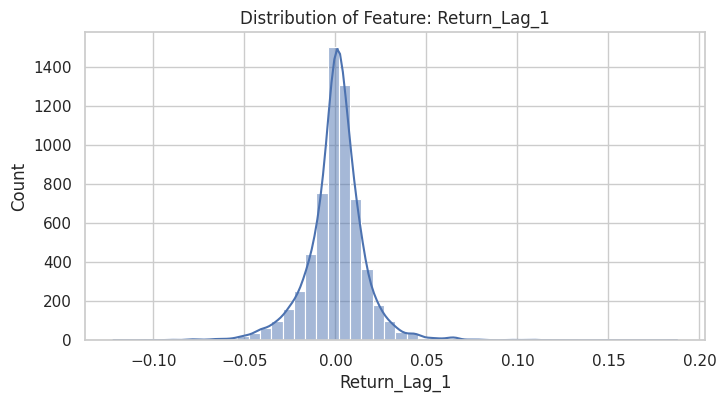

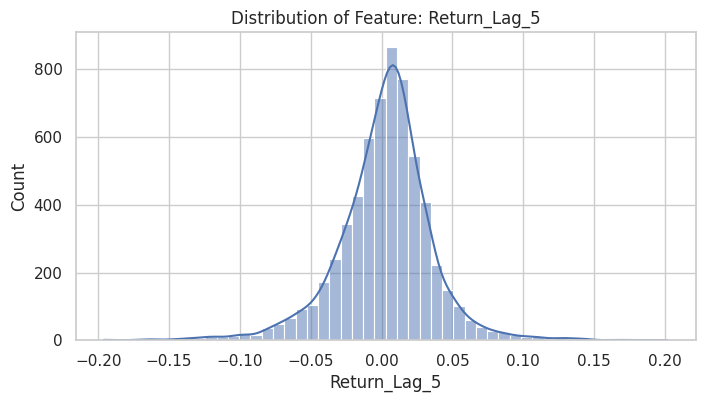

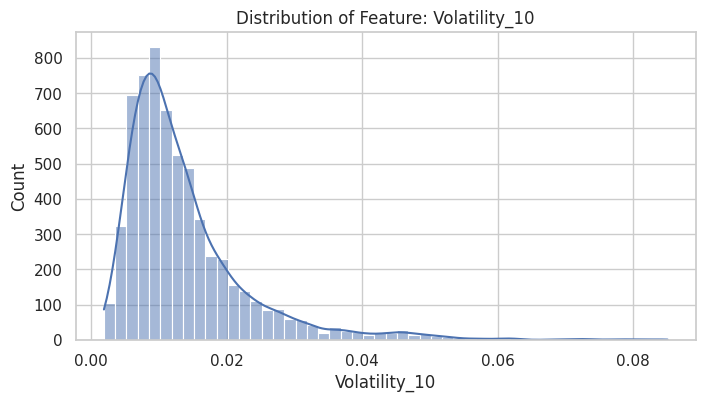

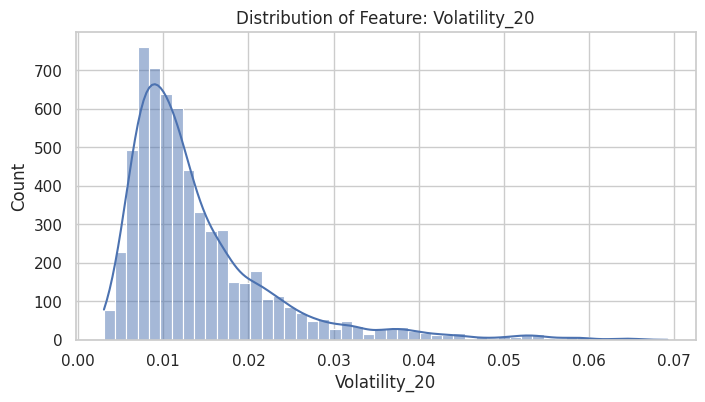

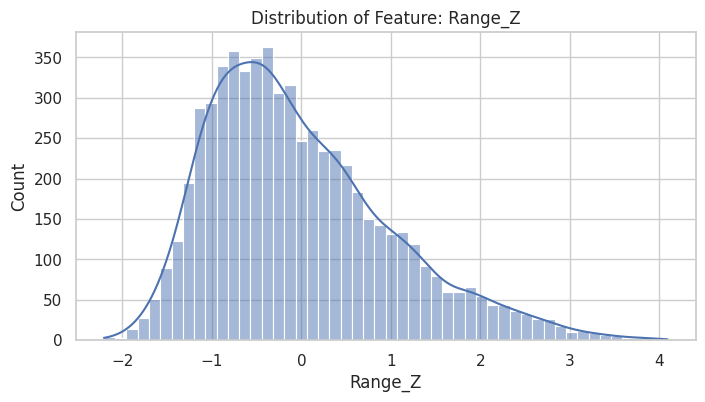

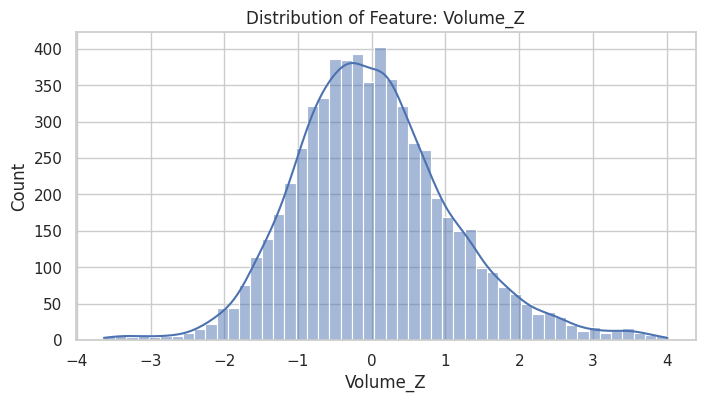

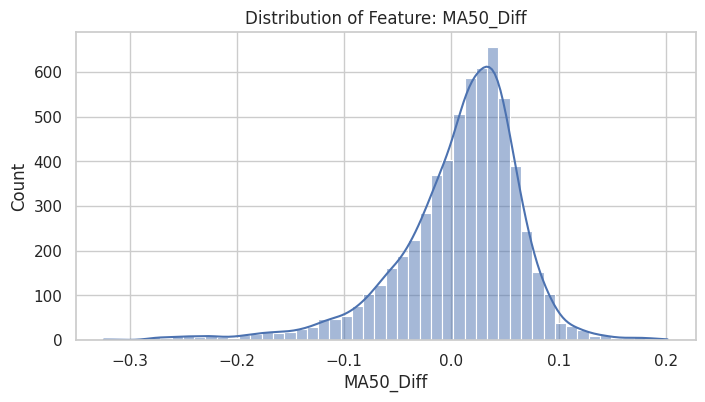

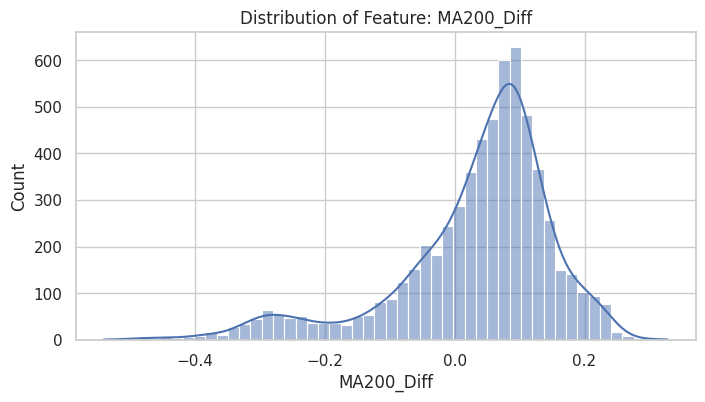

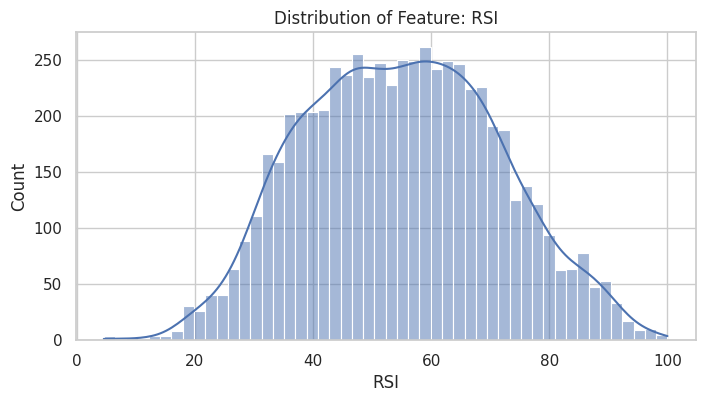

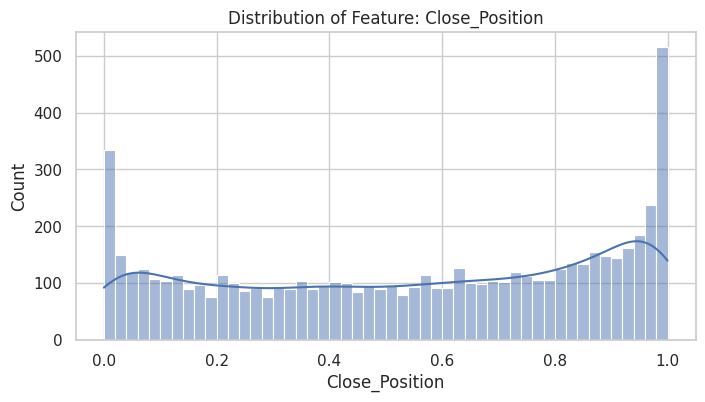

In [113]:
# Summary plot of feature distributions
import scipy.stats as stats
features_to_plot = ['Return_Lag_1', 'Return_Lag_5', 'Volatility_10', 'Volatility_20',
                    'Range_Z', 'Volume_Z', 'MA50_Diff', 'MA200_Diff', 'RSI', 'Close_Position']

for feature in features_to_plot:
    plt.figure(figsize=(8,4))
    sns.histplot(df[feature], bins=50, kde=True)
    plt.title(f"Distribution of Feature: {feature}")
    plt.xlabel(feature)
    plt.grid(True)
    plt.show()

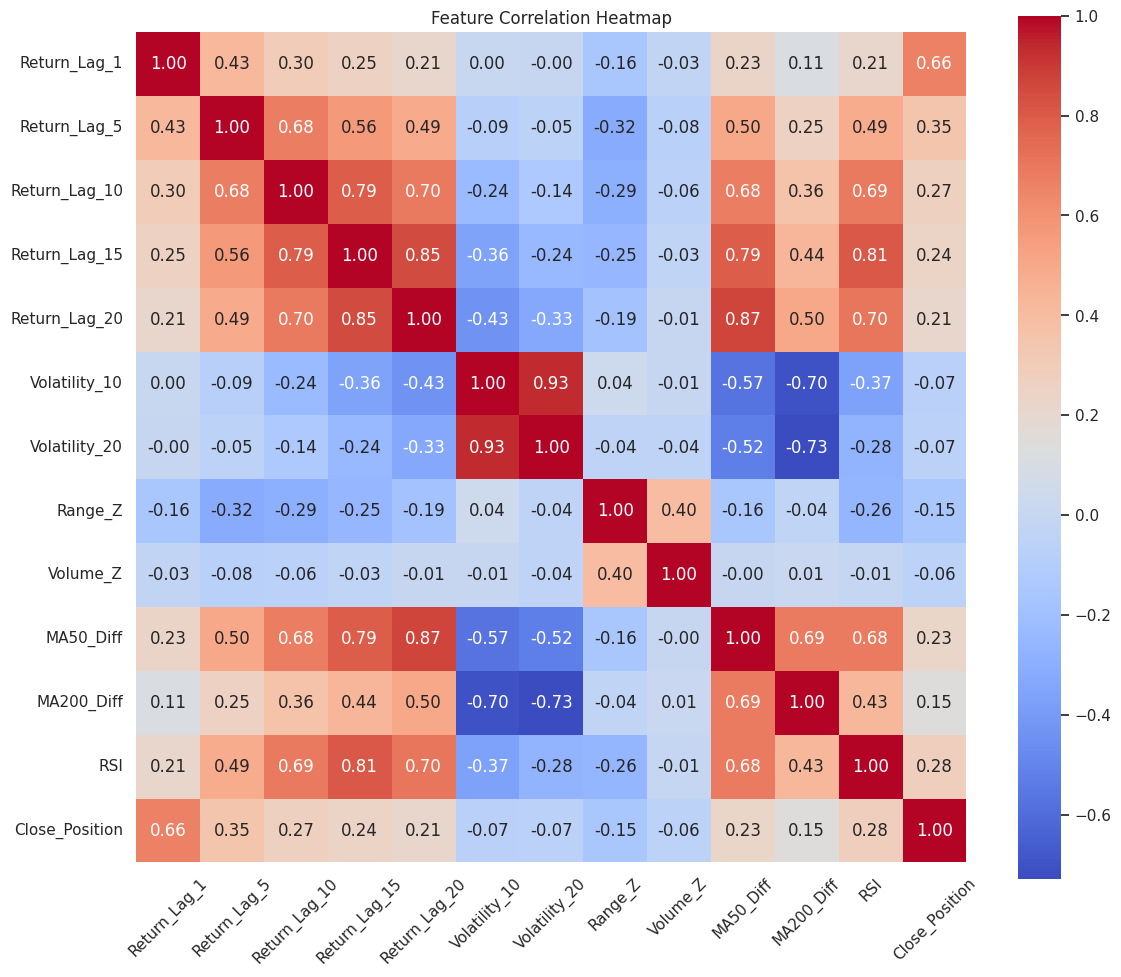

In [114]:
# Correlation heatmap among numeric features
feature_cols = ['Return_Lag_1', 'Return_Lag_5', 'Return_Lag_10', 'Return_Lag_15', 'Return_Lag_20',
                'Volatility_10', 'Volatility_20', 'Range_Z', 'Volume_Z',
                'MA50_Diff', 'MA200_Diff', 'RSI', 'Close_Position']

corr_matrix = df[feature_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [115]:
# Flag pairs with high correlation (|ρ| > 0.90)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > 0.90:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr))

print("Highly Correlated Feature Pairs (|ρ| > 0.90):")
for pair in high_corr_pairs:
    print(pair)

Highly Correlated Feature Pairs (|ρ| > 0.90):
('Volatility_20', 'Volatility_10', np.float64(0.9331480095403648))


Removing 'Volatility_20' from the feature set, as this largely replicates the exposure of the target prediction from 'Volatility_10', thus giving too much weight to the volatility predictor.

In [116]:
feature_cols.remove('Volatility_20')

In [117]:
# Low variance features check
feature_std = df[feature_cols].std()
low_var_features = feature_std[feature_std < 1e-4].index.tolist()
print("Low Variance Features (std < 1e-4):")
print(low_var_features)

Low Variance Features (std < 1e-4):
[]


In [118]:
# Define feature matrix and target
target = 'Target'
features = [col for col in df.columns if col.startswith(('Return_Lag_', 'Volatility_', 'Range_Z', 'Volume_Z', 'MA50_Diff', 'MA200_Diff', 'RSI', 'Close_Position', 'Weekday_', 'Month_'))]
X = df[features]
y = df[target]
y

,Target
199,0
200,0
201,1
202,1
203,0
...,...
6394,1
6395,0
6396,1
6397,0


In [119]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
print(f"Training set size, Test set size: {len(X_train)}, {len(X_test)}")

Training set size, Test set size: 4960, 1240


Feature Scaling

In [122]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Handling Imbalanced Class Distribution
Note that the NASDAQ-100 has done incredibly well over the period used to train our model. As a result, without any adjustment it will be highly biased toward predicting the majority class (i.e. a positive daily return). We adjust the model in XGBoost for this below.

In [ ]:
# class weight function
def cwts(dfs):
    c0, c1 = np.bincount(dfs)
    w0=(1/c0)*(len(df))/2
    w1=(1/c1)*(len(df))/2
    return {0: w0, 1: w1}

In [78]:
# base model (default parameters)
base_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
base_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [79]:
# Predictions and evaluation
train_preds = base_model.predict(X_train)
test_preds = base_model.predict(X_test)
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 0.9933
Test Accuracy: 0.5379


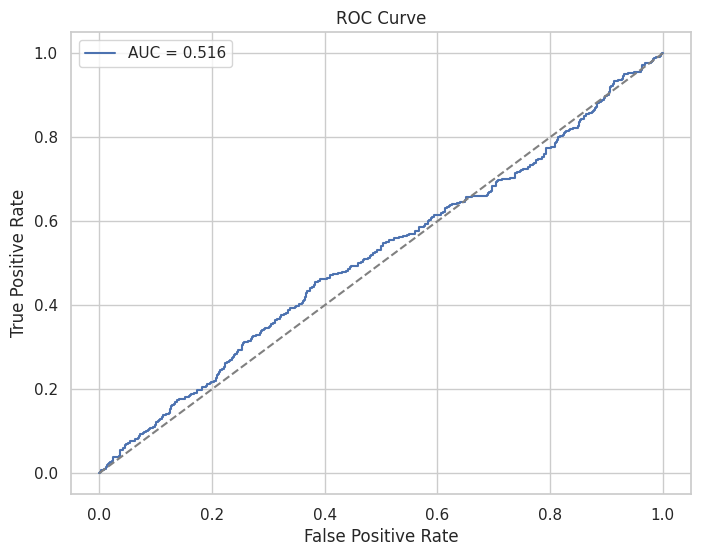

In [80]:
# ROC and AUC
probs = base_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, probs)
auc_score = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

In [81]:
# confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_preds))

Confusion Matrix:
[[449 239]
 [334 218]]


In [82]:
# classification report
print("Classification Report:")
print(classification_report(y_test, test_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.65      0.61       688
           1       0.48      0.39      0.43       552

    accuracy                           0.54      1240
   macro avg       0.53      0.52      0.52      1240
weighted avg       0.53      0.54      0.53      1240



In [83]:
# Hyperparameter Tuning
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7]
}

cv = TimeSeriesSplit(n_splits=5)
tuner = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                            param_distributions=param_grid,
                            scoring='roc_auc',
                            cv=cv,
                            n_iter=30,
                            random_state=42,
                            verbose=1)
tuner.fit(X_train, y_train)
best_model = tuner.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [84]:
# Final tuned model evaluation
train_pred_best = best_model.predict(X_train)
test_pred_best = best_model.predict(X_test)

In [85]:
train_acc_best = accuracy_score(y_train, train_pred_best)
test_acc_best = accuracy_score(y_test, test_pred_best)
print(f"Tuned Model Training Accuracy: {train_acc_best:.4f}")
print(f"Tuned Model Test Accuracy: {test_acc_best:.4f}")

Tuned Model Training Accuracy: 0.5784
Tuned Model Test Accuracy: 0.5468


In [86]:
probs_best = best_model.predict_proba(X_test)[:, 1]
fpr_best, tpr_best, _ = roc_curve(y_test, probs_best)
auc_best = auc(fpr_best, tpr_best)

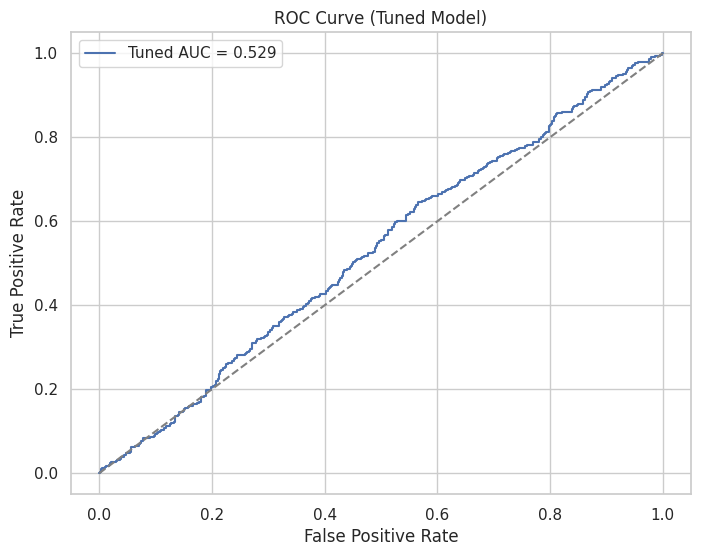

In [87]:
plt.figure(figsize=(8,6))
plt.plot(fpr_best, tpr_best, label=f'Tuned AUC = {auc_best:.3f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.title('ROC Curve (Tuned Model)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

In [88]:
# SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

AssertionError: Summary plots need a matrix of shap_values, not a vector.

In [ ]:
print("Tuned Model Confusion Matrix:")
print(confusion_matrix(y_test, test_pred_best))

In [ ]:
print("Tuned Model Classification Report:")
print(classification_report(y_test, test_pred_best))